In [1]:
import os, sys
sys.path.append("..")
from ipdb import set_trace

MODEL_HOME = "~/Downloads"
save_dir = os.path.expanduser(MODEL_HOME)
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from common_utils import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1
class_dict =  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
class_dict = {v:k for k, v in class_dict.items()}

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [4]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy, IOU
import numpy as np
conf = []
with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        if _ == 300:
            break
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        labels_map = {}
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                labels_map[(i, j)] = res[:, i, j][-20:]

        # non-max suppression
        lo = 0
        while lo < len(boxes):
            del_inds = set()
            conf.append(boxes[lo][4])
            if boxes[lo][4] < 0.01:
                del_inds.add(lo) 
            for j in range(lo+1, len(boxes)):
                if IOU(boxes[lo], boxes[j]) > 0.1:
                    if boxes[lo][4] > boxes[j][4]:
                        del_inds.add(j)
                    else:
                        del_inds.add(lo)
            boxes = np.delete(boxes, list(del_inds), axis=0)
            if lo in del_inds:
                lo = 0
            else:
                lo += 1

        # assign labels
        titles = []
        for x, y, _, _, _ in boxes:
            x_ind, y_ind = min(6, int(x * 7)), min(6, int(y * 7))
            class_arr = labels_map[(x_ind, y_ind)]
            _, max_class = max((value, index) for index, value in enumerate(class_arr))
            titles.append(class_dict[max_class])
        boxes = list(map(xywh_2_xxyy, boxes))
        
        # display prediction
        display_image_bbox(batch[0], boxes, titles)

        # display labels
        y_classes = [class_dict[c] for c in classes[0]]
        labels[0] = list(map(xywh_2_xxyy, labels[0]))
        display_image_bbox(batch[0], labels[0], y_classes)

In [9]:
conf = np.array(conf)
conf.std(), conf.mean(), conf.min(), conf.max()

(0.031342767, 0.01619071, 0.0018244975, 0.41727796)

### show loss curves


loss_df:               l1        l2        l3         l4         l5
0      1.001648  1.951319  0.261328  47.461021  14.968498
1      1.893589  5.585196  1.028212  45.967247  29.975222
2      1.215830  4.838565  0.877435  46.473064  24.972322
3      0.205763  1.382198  0.178491  47.457954  14.988590
4      3.541496  5.523600  1.169986  44.951679  39.966038
...         ...       ...       ...        ...        ...
11016  0.334479  1.480538  0.534487   0.077129   2.958567
11017  0.011644  3.418709  0.124367   0.050260   2.367063
11018  0.357801  3.315234  0.484938   0.030118   4.511425
11019  0.265455  0.338256  0.254512   0.038020   3.141301
11020  0.815542  0.802882  0.550029   0.067680   5.653873

[11021 rows x 5 columns]


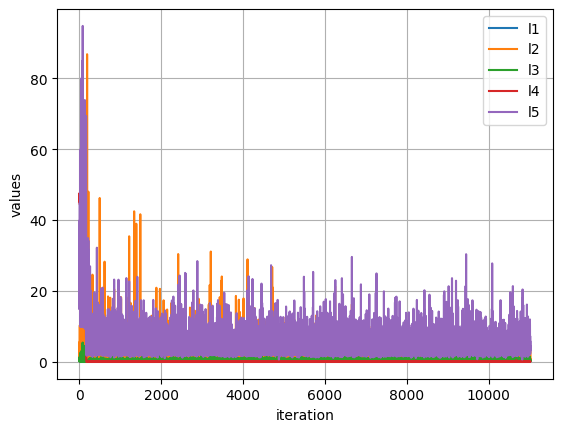

loss_df:               l1         l2        l3         l4         l5
0      1.223943   2.044841  0.324159  47.456104  14.991601
1      6.306737  12.761760  2.288127  43.467209  54.988724
2      2.205051   1.658963  0.584927  45.941696  30.009148
3      1.223128   1.858276  0.446367  46.438576  24.946293
4      1.736583   0.828002  0.506418  46.933834  19.972090
...         ...        ...       ...        ...        ...
11016  1.706842   6.406391  0.785248   0.045771  15.976785
11017  0.150605   0.348343  0.308171   0.107786   2.094281
11018  0.094702   1.437110  0.149317   0.055674   1.947533
11019  0.150533   0.528887  0.172162   0.069270   1.720570
11020  0.638320   3.382350  1.051577   0.045063   6.975940

[11021 rows x 5 columns]


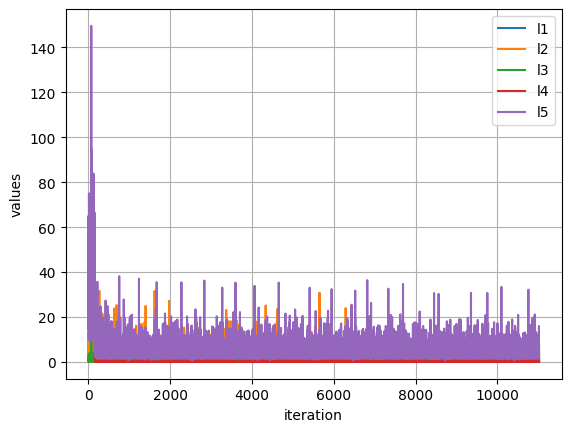

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser(save_dir)
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        # if col == "l1" or col == "l2": #or col == "l5":
        plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()